# Regressão logística, Análise de Discriminante Gaussiano, Naive Bayes Gaussiano, K-Nearest Neighbors e Árvore de decisão.

$\bf{Aluno}$: Danilo Alves Oliveira

## Geral para os algoritmos

In [2]:
import numpy as np

import matplotlib.pyplot as plt  # Biblioteca para gerar gráficos
from sklearn.model_selection import KFold # Para separação do k-folds
from sklearn.tree import DecisionTreeClassifier # Para a árvore de decisão
from sklearn import tree

# para exibir os dados em tabela
import pandas as pd
from pandas.io.formats.style import Styler
from jinja2 import Environment, ChoiceLoader, FileSystemLoader
from IPython.display import HTML

dataset = np.genfromtxt('./breastcancer.csv', delimiter=',')


C:\Users\danil\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\danil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\danil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


## Questão 1

Considere o conjunto de dados disponível em breastcancer.csv, organizado
em 31 colunas, sendo as 30 primeiras colunas os atributos e a última coluna a
saída. Os 30 atributos coletados de exames médicos são usados no diagnóstico
do câncer de mama, sendo 1 a classe positiva e 0 a classe negativa. Maiores
detalhes sobre os dados podem ser conferidos em https://scikit-learn.org/
stable/datasets/toy_dataset.html#breast-cancer-dataset.

a) Considerando uma validação cruzada em 10 folds, avalie modelos de classificação binária nos dados em questão. Para tanto, use as abordagens abaixo:

* Regressão logística (treinado com GD ou SGD);
* Análise do discriminante Gaussiano;
* Naive Bayes Gaussiano;
* KNN (escolha k = 3 e distância Euclidiana);
* Árvore de decisão (você pode usar uma implementação já existente com índice de impureza de gini)

b) Para cada modelo criado, reporte valor médio e desvio padrão das métricas de acurácia, revocação, precisão e F1-score.

### Funções gerais

In [3]:
# dicionários para armazenar as métricas dos algoritmos após o K-folds
dic= {}

# Separa nos vetores de entrada e saída
X = dataset[:, 0:30]
y = dataset[:, [dataset.shape[1]-1]]

# Configura o K-folds
kf = KFold(n_splits=10)

# funções comuns para os algoritmos
def clacularMetricas(y_pred, y):
    VP = np.sum((y_pred[np.where(y==1)] == 1) == True)
    VN = np.sum((y_pred[np.where(y==0)] == 0) == True)
    FP = np.sum((y_pred[np.where(y==0)] == 1) == True)
    FN = np.sum((y_pred[np.where(y==1)] == 0) == True)
    
    Acc = (VP + VN)/(VP + VN + FP + FN)
    Pre = VP/(VP + FP)
    Rec = VP/(VP + FN)
    F1  = 2*(Pre*Rec/(Pre + Rec))
    
    return Acc, Pre, Rec, F1, VP, VN, FP, FN

# classe para estilo da tabela
class MyStyler(Styler):
    env = Environment(
        loader=ChoiceLoader([
            FileSystemLoader("templates"),  # contains ours
            Styler.loader,  # the default
        ])
    )
    template = env.get_template("format.tpl")

# classe para exibir os resultados na tabela
def exibirResultados(algoritmo, accs, pres, recs, f1s, vps, vns, fps, fns):
    data = np.c_[accs, pres, recs, f1s, vps, vns, fps, fns]
    df1 = pd.DataFrame(data, columns=["Acuracy", "Precision", "Recall", "F1-score", "VP", "VN", "FP", "FN"])
    
    df2 = pd.DataFrame({"Acuracy": [np.mean(accs), np.std(accs), np.max(accs), np.min(accs)], 
                        "Precision": [np.mean(pres), np.std(pres), np.max(pres), np.min(pres)], 
                        "Recall": [np.mean(recs), np.std(recs), np.max(recs), np.min(recs)], 
                        "F1-score": [np.mean(f1s), np.std(f1s), np.max(f1s), np.min(f1s)]}, index=["mean", "std", "max", "min"])
    
    return HTML(MyStyler(df1).render(table_title="Metrics %s" % algoritmo)), HTML(MyStyler(df2).render(table_title="Summary %s" % algoritmo))

### 1. Regressão logística

A regressão logística é um método de classificação que utiliza modificações no algoritmo de regressão liniar para ter um achatamento após a transformação linear. Esse achatamento é feito por uma função logística na saída do modelo linear e através dessa modificação pode ser utilizado para categorizar classes. Dessa forma, considerando um padrão de entrada como um vetor $\mathbf{x}_{i}$, os parâmetros do modelo como um vetor $\mathbf{w}$, então a saída predita $\mathbf{\hat{y}_{i}}$ é calculado como:

$$\hat{y}_{i} = \sigma(\mathbf{w}^T \mathbf{x}_{i}).$$

Em que $\sigma$ é uma função logística. Nessa implementação a função desse tipo utilizada foi a sigmóide, definida como:

$$\sigma(x) = \frac{1}{1+e^{-x}}.$$

Essa função permite uma imagem definida no intervalo $[0,1]$ tornando formidável a interpretação probabilística da saída do modelo e associando ao grau de pertencimento de determinado padão de entrada a uma determinada classe do problema. Nessa implementação foi realizada uma regressão logística binária com atualização dos parâmetros via gradiente descendente, utilizando a regra:

$$ \mathbf{w} = \mathbf{w}_{t-1} + \frac{\alpha \mathbf{X}_{treino}^T \mathbf{e}}{N}. $$

Em que, $\mathbf{w}$ é o vetor de pesos de uma nova iteração, $\mathbf{X}_{treino}$ é o vetor com as amostras de treinamento, $\mathbf{w}_{t-1}$ é o vetor da iteração anterior, $N$ é a quantidade de amostras utilizadas para o treinamento do modelo e $\mathbf{e}$ é o vetor com os erros do modelo. Esse vetor de erros é calculado como:

$$\mathbf{e} = \mathbf{y} - \mathbf{\hat{y}}.$$

Em que $\mathbf{y}$ é o vetor com os valores corretos das classes e $\mathbf{\hat{y}}$ é o vetor com as predições do modelo de forma que $\mathbf{\hat{y}} = [\hat{y}_{1}, \hat{y}_{2}, ..., \hat{y}_{i}]$ calculados de acordo com a equação de $\hat{y}_{i}$ apresentada anteriormente. Além disso, também é utilizado o $\textit{Root-mean-square error}$(RMSE) para visualização das curvas de aprendizado durante as iterações do K-folds.

In [4]:
# definindo a função logística sigmóide
def sigmoide(z):
    return 1/(1 + np.exp(-z))


K =  1
K =  2
K =  3
K =  4
K =  5
K =  6
K =  7
K =  8
K =  9
K =  10


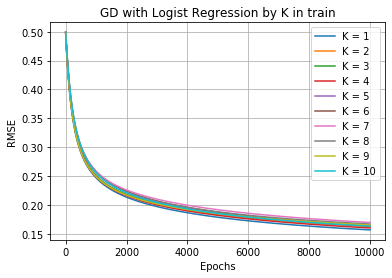

In [19]:

# valores de alpha e épocas
alpha = 0.07
epochs = 10000

#vetores para armazenar as métricas nas interações do k-folds
vet_acc = []
vet_pre = []
vet_rec = []
vet_f1 = []

vet_vps = []
vet_vns = []
vet_fps = []
vet_fns = []

K = 1

# Iterações do K-folds
for train_index, test_index in kf.split(X):
    
    print("K = ", K)
    
    # limpa o vetor de RMSE para obter o do K corrente
    erros_train = []
    
    # Divisão dos grupos de treino e teste da iteração
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    
    # Normalização dos dados
    X_train_norm = (X_train - X_train.min(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0))
    X_test_norm = (X_test - X_test.min(axis=0)) / (X_test.max(axis=0) - X_test.min(axis=0))
    
    # Adiciona coluna de 1
    X_train_norm = np.c_[np.ones(X_train_norm.shape[0]), X_train_norm[:, :]]
    X_test_norm = np.c_[np.ones(X_test_norm.shape[0]), X_test_norm[:, :]]
    
    # Dimensiona o tamanho do vetor pesos
    W = np.zeros((X_train_norm.shape[1], 1))
    
    # Iterações do SGD
    for k in range(0, epochs):
    
        # Calculo da predição e do erro
        y_pred = sigmoide(X_train_norm @ W)
        
        e = y_train - y_pred

        # Atualiza parâmetros
        W += alpha * X_train_norm.T @ e / X_train_norm.shape[0]
        
        # Nova predição com os parâmetros atualizados para cálculo da RMSE de treino
        y_pred = sigmoide(X_train_norm @ W)
        
        RMSE_train = np.sqrt(np.mean((y_train - y_pred)**2, axis=0))
        erros_train.append(RMSE_train)
    
    # Realiza a predição de teste com os parâmetros treinados
    y_pred = sigmoide(X_test_norm @ W)
    pred_class = np.around(y_pred)
    
    # Calcula as métricas
    Acc, Pre, Rec, F1, VP, VN, FP, FN = clacularMetricas(pred_class, y_test)
    vet_acc.append(Acc)
    vet_pre.append(Pre)
    vet_rec.append(Rec)
    vet_f1.append(F1)
    vet_vps.append(VP)
    vet_vns.append(VN)
    vet_fps.append(FP)
    vet_fns.append(FN)
    
    # Plotagem da curva de aprendizagem para o K
    plt.plot(range(0,epochs), erros_train, label='K = %s' % K)
    plt.xlabel("Epochs")
    plt.title('GD with Logist Regression by K in train')
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    
    K+=1

plt.show()

Após a cross-validation é apresentado o gráfico de treinamento analisando a curva de aprendizagem a cada iteração do k, esse gráfico serviu para avaliar se o modelo estava convergindo com os parâmetros configurados. Os resultados das iterações dos folds e os cálculos das médias, desvio padrão, máximos e mínimos das métricas são apresentados nas tabelas abaixo:

In [20]:
a,b = exibirResultados("Logistic Regression", vet_acc, vet_pre, vet_rec, vet_f1, vet_vps, vet_vns, vet_fps, vet_fns)
dic["LR"] = b

display(a)
display(b)

,Acuracy,Precision,Recall,F1-score,VP,VN,FP,FN
0,0.982456,1.000000,0.909091,0.952381,10.000000,46.000000,0.000000,1.000000
1,0.877193,1.000000,0.800000,0.888889,28.000000,22.000000,0.000000,7.000000
2,0.859649,1.000000,0.777778,0.875000,28.000000,21.000000,0.000000,8.000000
3,0.964912,0.935484,1.000000,0.966667,29.000000,26.000000,2.000000,0.000000
4,1.000000,1.000000,1.000000,1.000000,29.000000,28.000000,0.000000,0.000000
5,0.877193,0.975000,0.866667,0.917647,39.000000,11.000000,1.000000,6.000000
6,0.964912,1.000000,0.951220,0.975000,39.000000,16.000000,0.000000,2.000000
7,0.912281,1.000000,0.886364,0.939759,39.000000,13.000000,0.000000,5.000000
8,0.982456,1.000000,0.977273,0.988506,43.000000,13.000000,0.000000,1.000000
9,0.892857,1.000000,0.860465,0.925000,37.000000,13.000000,0.000000,6.000000


,Acuracy,Precision,Recall,F1-score
mean,0.931391,0.991048,0.902886,0.942885
std,0.050042,0.019965,0.075095,0.039397
max,1.000000,1.000000,1.000000,1.000000
min,0.859649,0.935484,0.777778,0.875000


### 2. Análise do discriminante Gaussiano

Nesse modelo estatístico, a classificação é obtida através de probabilidade de pertencimento calculadas para cada amostra em relação as classes. Nesse problema de classificação binária, a Análise do Discriminante Gaussiano (ADG) busca calcular as probabilidades $p(C_{1}|\mathbf{x})$ e $p(C_{2}|\mathbf{x})$ e selecionar a que possuir maior valor. No ADG a verossimilhança da classe é calculadas considerando que os dados correspondem a uma distribuição gaussiana e os parâmetros são estimados baseados nessa consideração. Dessa forma, a probabilidade de uma classe $k$ ser atribuída para um padrão $\mathbf{x}$ é dado por:

$$p(C_{k}|\mathbf{x}) = - \frac{1}{2}log|\Sigma_{k}|-\frac{1}{2}(\mathbf{x}-\mathbf{\mu_{k}})^{T}\Sigma_{k}^{-1}(\mathbf{x}-\mathbf{\mu_{k}})+log p(C_{k}).$$

Em que, $\Sigma_{k}$ é a matriz de covariância da classe $k$, $\mu_{k}$ é o vetor de médias e $p(C_{k})$ é a probabilidade a priori. A matriz de covariância pode ser calculada por:

$$\Sigma_{k} = \frac{1}{N_{k}-1}\sum_{x_{i}\in C_{k}}(x_{i}-\hat{\mu}_{k})(x_{i}-\hat{\mu}_{k})^{T}.$$

Em que, $N_{k}$ é a quantidade de amostras da classe $k$, $x$ são as amostras da classe $k$ e $\hat{\mu}_{k}$ são as médias da classe $k$. Importante ressaltar que essas estimações são calculadas somente para dados do grupo de treino. As médias são calculadas como:

$$ \hat{\mu}_{k} = \frac{1}{N_{k}} \sum_{x_{i} \in C_{k}} x_{i}.$$

Nessa implementação, $\Sigma_{k}$ foi calculada de forma matricial considerando todas as amostras de treino de $x_{treino}$ sem realizar iterações. Os calculos de probabilidade das amostras de teste foram feitos também de forma matricial, mas realizando iterações dentro do vetor $x_{teste}$. Por serem duas classes, são calculadas duas probabilidades de pertencimento e selecionada a que possuir maior valor.

In [7]:

#vetores para armazenar as métricas nas interações do k-folds
vet_acc = []
vet_pre = []
vet_rec = []
vet_f1 = []

vet_vps = []
vet_vns = []
vet_fps = []
vet_fns = []

# Iterações do K-folds
for train_index, test_index in kf.split(X):
    
    # Divisão dos grupos de treino e teste da iteração
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    
    # obtém as entradas de cada classe
    X_train0 = X_train[np.where(y_train == 0)[0]]
    X_train1 = X_train[np.where(y_train == 1)[0]]

    # médias das classes
    u_train0, u_train1 = np.mean(X_train0, axis=0), np.mean(X_train1, axis=0)
    
    # estimação das probabilidades a priori
    p0 = X_train0.shape[0]/X_train.shape[0]
    p1 = X_train1.shape[0]/X_train.shape[0]
    
    # matrizes de covariância
    cov0 = 1/(X_train0.shape[0] - 1) * np.sum([np.array(X_train0 - u_train0).T @ np.array(X_train0 - u_train0)], axis=0)
    cov1 = 1/(X_train1.shape[0] - 1) * np.sum([np.array(X_train1 - u_train1).T @ np.array(X_train1 - u_train1)], axis=0)
    
    # realiza as probabilidades para cada classe para o grupo de teste
    pred0 = np.array([- (1/2) * np.log(np.linalg.det(cov0)) - (1/2) * (X_test[i] - u_train0).T @ 
                  (np.linalg.inv(cov0) @ (X_test[i] - u_train0)) + np.log(p0) for i in range(0, X_test.shape[0])])

    pred1 = np.array([- (1/2) * np.log(np.linalg.det(cov1)) - (1/2) * (X_test[i] - u_train1).T @ 
                      (np.linalg.inv(cov1) @ (X_test[i] - u_train1)) + np.log(p1) for i in range(0, X_test.shape[0])])
    
    # prepara o vetor de previsões para as probabilidades obtidas
    pred = np.zeros(y_test.shape)
    pred[pred1>pred0] = 1
    
    # Calcula as métricas
    Acc, Pre, Rec, F1, VP, VN, FP, FN = clacularMetricas(pred, y_test)
    vet_acc.append(Acc)
    vet_pre.append(Pre)
    vet_rec.append(Rec)
    vet_f1.append(F1)
    vet_vps.append(VP)
    vet_vns.append(VN)
    vet_fps.append(FP)
    vet_fns.append(FN)   

# exibindo os resultados
a,b = exibirResultados("Gaussian Discriminant Analysis", vet_acc, vet_pre, vet_rec, vet_f1, vet_vps, vet_vns, vet_fps, vet_fns)
dic["GDA"] = b

display(a)
display(b)

,Acuracy,Precision,Recall,F1-score,VP,VN,FP,FN
0,0.964912,0.846154,1.000000,0.916667,11.000000,44.000000,2.000000,0.000000
1,0.929825,0.918919,0.971429,0.944444,34.000000,19.000000,3.000000,1.000000
2,0.964912,0.972222,0.972222,0.972222,35.000000,20.000000,1.000000,1.000000
3,0.964912,0.965517,0.965517,0.965517,28.000000,27.000000,1.000000,1.000000
4,0.964912,0.935484,1.000000,0.966667,29.000000,26.000000,2.000000,0.000000
5,0.947368,0.977273,0.955556,0.966292,43.000000,11.000000,1.000000,2.000000
6,0.964912,0.975610,0.975610,0.975610,40.000000,15.000000,1.000000,1.000000
7,0.964912,0.977273,0.977273,0.977273,43.000000,12.000000,1.000000,1.000000
8,0.947368,1.000000,0.931818,0.964706,41.000000,13.000000,0.000000,3.000000
9,0.964286,1.000000,0.953488,0.976190,41.000000,13.000000,0.000000,2.000000


,Acuracy,Precision,Recall,F1-score
mean,0.957832,0.956845,0.970291,0.962559
std,0.011601,0.044012,0.019621,0.017733
max,0.964912,1.000000,1.000000,0.977273
min,0.929825,0.846154,0.931818,0.916667


### 3. Naive Bayes Gaussiano

Esse classificador realiza considerações no algoritmo de Análise do discriminante Gaussiano, modificando para que os atributos sejam tratados como idependentes, dado uma classe do padrão. Dessa forma, o cálculo das probabilidades para cada amostra é simplificado, tornando coveniente mas gerando uma suposição muito forte que é provavél não ser verdadeira em dados reais. No entanto, esse classificador apresentar resultados consideravéis mesmo para dados que não obedecem essa suposição. Essa consideração do algoritmo provaca modificações nos calculos de predição, resultando em uma abordagem diferente para obter a predição para um novo padrão. Dessa forma, para um novo padrão $\mathbf{x_{*}}$ a classe predita é obtida como:
$$\hat{y}_{*} = arg_{k}max \left [log p(C_{k}) - \frac{1}{2} \sum_{d=1}^{D} log 2\pi\sigma^{2}_{dk} - \frac{1}{2}\sum_{d=1}^{D}\frac{(x_{*d} - \mu_{dk})^{2}}{\sigma^{2}_{dk}}  \right ]$$

Em que, $p(C_{k})$ é a probabilidade a priori da nova amostra ser pertencente a classe, $\sigma^{2}_{dk}$ é a variância da classe e $\mu_{dk}$ é a média dos dados da classe. Esses valores são estimados para cada classe $k$ com os dados do grupo de treino. Nessa implementação, a probabilidade a priori foi estimada com base na quantidade de amostras para cada classe no conjunto, dessa forma:
$$p(C_{k}) = \frac{N_{k}}{N}$$

Em que $N_{k}$ é a quantidade de amostras da classe $k$ presentes no grupo de treino e $N$ é o total de amostras. Os valores de $\sigma^{2}_{dk}$ e $\mu_{dk}$ são calculados como:

$$\sigma^{2}_{dk} = \frac{1}{N_{k}-1}\sum_{x_{i \in C_{k}}}(x_{id}-\hat{\mu}_{dk})^2 $$

$$\mu_{dk} = \frac{1}{N_{k}}\sum_{x_{i} \in C_{k}} x_{id} $$

In [8]:

#vetores para armazenar as métricas nas interações do k-folds
vet_acc = []
vet_pre = []
vet_rec = []
vet_f1 = []

vet_vps = []
vet_vns = []
vet_fps = []
vet_fns = []

# Iterações do K-folds
for train_index, test_index in kf.split(X):
    
    # Divisão dos grupos de treino e teste da iteração
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    
    # obtém as entradas de cada classe
    X_train0 = X_train[np.where(y_train == 0)[0]]
    X_train1 = X_train[np.where(y_train == 1)[0]]
    
    # estimação das probabilidades a priori
    p0 = X_train0.shape[0]/X_train.shape[0]
    p1 = X_train1.shape[0]/X_train.shape[0]

    # médias das classes
    u_train0, u_train1 = np.mean(X_train0, axis=0), np.mean(X_train1, axis=0)
    
    # variância das classes
    var_0 = (1/(X_train0.shape[0] - 1)) * np.sum((X_train0 - u_train0)**2, axis=0)
    var_1 = (1/(X_train1.shape[0] - 1)) * np.sum((X_train1 - u_train1)**2, axis=0)
    
    # predição para os padrões de teste
    y0 = np.array([np.log(p0) - (1/2)*np.sum(np.log(2*np.pi*var_0)) - (1/2)*np.sum(((X_test - u_train0)**2)/var_0, axis=1)])
    y1 = np.array([np.log(p1) - (1/2)*np.sum(np.log(2*np.pi*var_1)) - (1/2)*np.sum(((X_test - u_train1)**2)/var_1, axis=1)])

    # une as predições das duas classes e pega o índice do valor máximo
    yk = np.c_[y0.T, y1.T]
    pred = np.expand_dims(np.array([np.argmax([yk[i]]) for i in range(len(yk))]), axis=1)
    
    # Calcula as métricas
    Acc, Pre, Rec, F1, VP, VN, FP, FN = clacularMetricas(pred, y_test)
    vet_acc.append(Acc)
    vet_pre.append(Pre)
    vet_rec.append(Rec)
    vet_f1.append(F1)
    vet_vps.append(VP)
    vet_vns.append(VN)
    vet_fps.append(FP)
    vet_fns.append(FN)

# Apresenta os resultados
a,b = exibirResultados("Gaussian Naive Bayes", vet_acc, vet_pre, vet_rec, vet_f1, vet_vps, vet_vns, vet_fps, vet_fns)
dic["NBG"] = b

display(a)
display(b)

,Acuracy,Precision,Recall,F1-score,VP,VN,FP,FN
0,0.912281,0.687500,1.000000,0.814815,11.000000,41.000000,5.000000,0.000000
1,0.842105,0.861111,0.885714,0.873239,31.000000,17.000000,5.000000,4.000000
2,0.912281,0.942857,0.916667,0.929577,33.000000,19.000000,2.000000,3.000000
3,0.929825,0.878788,1.000000,0.935484,29.000000,24.000000,4.000000,0.000000
4,0.929825,0.931034,0.931034,0.931034,27.000000,26.000000,2.000000,2.000000
5,0.947368,0.977273,0.955556,0.966292,43.000000,11.000000,1.000000,2.000000
6,0.982456,0.976190,1.000000,0.987952,41.000000,15.000000,1.000000,0.000000
7,0.964912,0.977273,0.977273,0.977273,43.000000,12.000000,1.000000,1.000000
8,0.894737,1.000000,0.863636,0.926829,38.000000,13.000000,0.000000,6.000000
9,0.946429,0.954545,0.976744,0.965517,42.000000,11.000000,2.000000,1.000000


,Acuracy,Precision,Recall,F1-score
mean,0.926222,0.918657,0.950662,0.930801
std,0.037412,0.087841,0.046955,0.049695
max,0.982456,1.000000,1.000000,0.987952
min,0.842105,0.687500,0.863636,0.814815


## 4. K-Nearest Neighbors

O $\textit{K-Nerest Neighborhs}$ (KNN) é um modelo de aprendizado baseado em instância, os modelos desse tipo seguem a característica de ajustar sua regra de decisão de classes através das instâncias observadas. Dessa forma, não apresentam parâmetros ou etapa separada de treinamento e as predições são realizadas buscando as instâncias mais próximas do grupo de treinamento. A próximidade da instância é calculada com auxio de técnicas de distância, o KNN implementa comumente a distância euclidiana dada por:

$$d(x_{i}, x_{j}) = \sqrt{\sum_{d=1}^{D} (x_{id} - x_{jd})^2}$$

Em que $x_{i}$ e $x_{j}$ são as duas amostras que se deseje calcular a distância. A predição do KNN para uma nova amostra $\mathbf{x}_{*}$ pode ser implementada em duas etapas:
* Encontrar as $K$ amostras de treinamento $x_{k}$ mais próximas de $x_{*}$, com $k \in \left \{1, ..., K\right \}$:

$$\mathbf{x}_{KNN} = arg min_{x_{i} \in \left \{ x_{1}, . . ., x_{N} \right \}} d(x_{i}, x_{*})$$

* Obter as classes $\mathbf{y}_{KNN}$ das amostras mais próximas $\mathbf{x}_{KNN}$ e atribir como decisão do modelo a classe mais comun dentro de $\mathbf{y}_{KNN}$.

In [9]:
# valor de K
K = 3

#vetores para armazenar as métricas nas interações do k-folds
vet_acc = []
vet_pre = []
vet_rec = []
vet_f1 = []

vet_vps = []
vet_vns = []
vet_fps = []
vet_fns = []

# Iterações do K-folds
for train_index, test_index in kf.split(X):
    
    # Divisão dos grupos de treino e teste da iteração
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    
    # vetor das predições
    y_pred = []
    
    # Realiza predição para o grupo de teste verificando as 3 classes de treino mais próximas
    for j in range(X_test.shape[0]):
        # array com o tuplas classe e distância de todas as amostras de treino
        class_dist = [(y_train[i][0], np.sqrt(np.sum((X_test[j] - X_train[i])**2))) for i in range(len(X_train))]
        
        # forma um array estruturado por chave
        dtype = [('class', float), ('dist', float)]
        est = np.array(class_dist, dtype=dtype)
        
        # ordena o array de acordo com a coluna de distância
        est_ord = np.sort(est, order='dist')
        
        # obtém as K classes com menores distância e pega a mais frequente
        classes_proximas = [est_ord[0:K][i][0] for i in range(0,K)]
        count = np.bincount(classes_proximas)
        y_pred.append(np.argmax(count))
    
    # tranforma para enviar a função
    y_pred2 = np.array([[y_pred[i]] for i in range(len(y_pred))], dtype=float)
    
    # Calcula as métricas
    Acc, Pre, Rec, F1, VP, VN, FP, FN = clacularMetricas(y_pred2, y_test)
    vet_acc.append(Acc)
    vet_pre.append(Pre)
    vet_rec.append(Rec)
    vet_f1.append(F1)
    vet_vps.append(VP)
    vet_vns.append(VN)
    vet_fps.append(FP)
    vet_fns.append(FN)

# Apresenta os resultados
a,b = exibirResultados("K-Nearest Neighbors", vet_acc, vet_pre, vet_rec, vet_f1, vet_vps, vet_vns, vet_fps, vet_fns)
dic["KNN"] = b

display(a)
display(b)

,Acuracy,Precision,Recall,F1-score,VP,VN,FP,FN
0,0.789474,0.478261,1.000000,0.647059,11.000000,34.000000,12.000000,0.000000
1,0.929825,0.918919,0.971429,0.944444,34.000000,19.000000,3.000000,1.000000
2,0.929825,0.944444,0.944444,0.944444,34.000000,19.000000,2.000000,2.000000
3,0.877193,0.843750,0.931034,0.885246,27.000000,23.000000,5.000000,2.000000
4,0.964912,0.965517,0.965517,0.965517,28.000000,27.000000,1.000000,1.000000
5,0.964912,0.977778,0.977778,0.977778,44.000000,11.000000,1.000000,1.000000
6,0.947368,0.952381,0.975610,0.963855,40.000000,14.000000,2.000000,1.000000
7,0.964912,0.956522,1.000000,0.977778,44.000000,11.000000,2.000000,0.000000
8,0.929825,1.000000,0.909091,0.952381,40.000000,13.000000,0.000000,4.000000
9,0.928571,0.975610,0.930233,0.952381,40.000000,12.000000,1.000000,3.000000


,Acuracy,Precision,Recall,F1-score
mean,0.922682,0.901318,0.960514,0.921088
std,0.050952,0.146745,0.029115,0.094687
max,0.964912,1.000000,1.000000,0.977778
min,0.789474,0.478261,0.909091,0.647059


## 5. Decision Tree

Árvores de decisão são algoritmos que utilizam regras lógicas para separar padrões de acordo com seus atríbutos, esses métodos são não paramétricos e podem ser utilizados tanto para classificação quanto para regressão. Essa abrodagem segue a ideia da estrutura de dados de árvores, com algumas modificações. Essas estruturas possuem "nós internos" que verificam os atributos com uma condição lógica, semelhante ao comando "IF", e possuem "nós terminais", também chamados de folhas, que são a atribuição a uma classe do problema. Além disso, essas árvores possuem um nó mais superior, no qual todos os outros são ramificados, ele é chamado de "nó raiz", ele é o início da árvores. As regras dos nós das árvores são obtidos no processo de treinamento e os atributos para realizar as divisões nos ramos são selecionados através de índices de pureza. Nesse trabalho a árvore de decisão foi implementada atráves da biblioteca do scikit-learn e utiliza como padrão o índice de impureza Gini para a seleção dos melhores atributos nas divisões.

In [10]:
#vetores para armazenar as métricas nas interações do k-folds
vet_acc = []
vet_pre = []
vet_rec = []
vet_f1 = []

vet_vps = []
vet_vns = []
vet_fps = []
vet_fns = []

# vetor com os modelos
models = []

# Iterações do K-folds
for train_index, test_index in kf.split(X):
    
    # Divisão dos grupos de treino e teste da iteração
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    
    # cria o modelo
    model = DecisionTreeClassifier()
    
    # realiza o treinamento
    model = model.fit(X_train, y_train)
    
    #salva o modelo
    models.append(model)
    
    # realiza a predição
    y_pred = model.predict(X_test)
    y_pred = y_pred.reshape(y_pred.shape[0],1)
    
    # Calcula as métricas
    Acc, Pre, Rec, F1, VP, VN, FP, FN = clacularMetricas(y_pred, y_test)
    vet_acc.append(Acc)
    vet_pre.append(Pre)
    vet_rec.append(Rec)
    vet_f1.append(F1)
    vet_vps.append(VP)
    vet_vns.append(VN)
    vet_fps.append(FP)
    vet_fns.append(FN)

# Apresenta os resultados
a,b = exibirResultados("Decision Tree Classifier", vet_acc, vet_pre, vet_rec, vet_f1, vet_vps, vet_vns, vet_fps, vet_fns)
dic["DT"] = b

display(a)
display(b)    

,Acuracy,Precision,Recall,F1-score,VP,VN,FP,FN
0,0.912281,0.687500,1.000000,0.814815,11.000000,41.000000,5.000000,0.000000
1,0.912281,0.916667,0.942857,0.929577,33.000000,19.000000,3.000000,2.000000
2,0.877193,0.914286,0.888889,0.901408,32.000000,18.000000,3.000000,4.000000
3,0.947368,0.933333,0.965517,0.949153,28.000000,26.000000,2.000000,1.000000
4,0.912281,0.961538,0.862069,0.909091,25.000000,27.000000,1.000000,4.000000
5,0.982456,0.978261,1.000000,0.989011,45.000000,11.000000,1.000000,0.000000
6,0.912281,0.973684,0.902439,0.936709,37.000000,15.000000,1.000000,4.000000
7,0.947368,1.000000,0.931818,0.964706,41.000000,13.000000,0.000000,3.000000
8,0.912281,1.000000,0.886364,0.939759,39.000000,13.000000,0.000000,5.000000
9,0.946429,0.954545,0.976744,0.965517,42.000000,11.000000,2.000000,1.000000


,Acuracy,Precision,Recall,F1-score
mean,0.926222,0.931981,0.935670,0.929975
std,0.028001,0.086509,0.046970,0.045802
max,0.982456,1.000000,1.000000,0.989011
min,0.877193,0.687500,0.862069,0.814815


O código abaixo é para realizar a visualização das árvores de decisão treinadas e observar a forma como o algortimo montou a estrutura de decisão de acordo com os dados de treinamento. Como são realizados k treinamentos e a visualização aqui seria difícil, então optou-se por salvar as imagens das árvores de cada k. Os títulos correspondentes aos atributos são adicionados para que as árvores sejam mais interpretativas.

In [11]:
features = ['radius' ,'texture' ,'perimeter' ,'area' ,'smoothness' ,'compactness',
'concavity' ,'concave points', 'symmetry' ,'fractal dimension' ,'radius' ,'texture',
'perimeter' ,'area' ,'smoothness' ,'compactness' ,'concavity' ,'concave points',
'symmetry' ,'fractal dimension' ,'radius' ,'texture' ,'perimeter' ,'area',
'smoothness' ,'compactness' ,'concavity' ,'concave points' ,'symmetry' ,'fractal dimension']

class_names = ['WDBC-Benign','WDBC-Malignant']

# desabilitando a função de exibir automáticamente
plt.ioff()

for i in range(len(models)):
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(models[i], 
                       feature_names=features,  
                       class_names=class_names,
                       filled=True)

    fig.savefig("decistion_tree-k-%d.png" % i)
    plt.close(fig)

Após calculadas as métricas através da validação cruzada k-folds, os valores médios dessas métricas são exibidos a seguir para análise dos resultados entre diferentes modelos.

In [21]:
# apresentação das médias dos modelos
display(dic['LR'],dic['GDA'],dic['NBG'],dic['KNN'],dic["DT"])

,Acuracy,Precision,Recall,F1-score
mean,0.931391,0.991048,0.902886,0.942885
std,0.050042,0.019965,0.075095,0.039397
max,1.000000,1.000000,1.000000,1.000000
min,0.859649,0.935484,0.777778,0.875000


,Acuracy,Precision,Recall,F1-score
mean,0.957832,0.956845,0.970291,0.962559
std,0.011601,0.044012,0.019621,0.017733
max,0.964912,1.000000,1.000000,0.977273
min,0.929825,0.846154,0.931818,0.916667


,Acuracy,Precision,Recall,F1-score
mean,0.926222,0.918657,0.950662,0.930801
std,0.037412,0.087841,0.046955,0.049695
max,0.982456,1.000000,1.000000,0.987952
min,0.842105,0.687500,0.863636,0.814815


,Acuracy,Precision,Recall,F1-score
mean,0.922682,0.901318,0.960514,0.921088
std,0.050952,0.146745,0.029115,0.094687
max,0.964912,1.000000,1.000000,0.977778
min,0.789474,0.478261,0.909091,0.647059


,Acuracy,Precision,Recall,F1-score
mean,0.926222,0.931981,0.935670,0.929975
std,0.028001,0.086509,0.046970,0.045802
max,0.982456,1.000000,1.000000,0.989011
min,0.877193,0.687500,0.862069,0.814815


Através dessas tabelas observa-se que todos os classificadores apresentaram resultados promissores, com médias das métricas acima dos 90%. No entanto, anáisando os dados é possível perceber que o modelo com maior quantidade de maiores métricas foi a Análide do Discriminante Gaussiano com acurácia de 95,78%, recall de 97,02% e F1-score de 96,25%. A maior precisão foi da Regressão lógistica, com 99,10%.